In [13]:
import numpy as np
import torch
from math import pi
import matplotlib.pyplot as plt
import time
from ipywidgets import FloatSlider, Button, Output, VBox, HTML, HBox, Dropdown, interact, Output
from IPython.display import Image, display, clear_output

from test_functions1D import MultiMinimaFunc_numpy, Sinc_numpy, Sin_numpy
from test_functions1D import MultiMinimaFunc, Sinc, Sin

# ------------------------------------------------------------------------------------------------------------
# HJ Moreau Adaptive Descent
# ------------------------------------------------------------------------------------------------------------

class HJ_MAD:
    ''' 
        Hamilton-Jacobi Moreau Adaptive Descent (HJ_MAD) for nonconvex minimization.
        Inputs and Outputs descriptions remain unchanged.
    '''

    def __init__(self, f, x_true, delta=0.1, int_samples=100, t_vec = [1.0, 1e-3, 1e1], max_iters=5e4, 
                 tol=5e-2, theta=0.9, beta=[0.9], eta_vec = [0.9, 1.1], alpha=1.0, fixed_time=False, 
                 verbose=True, accelerated=False, plot_parameters = [-30,30,None]):
      
        self.delta            = delta
        self.f                = f
        self.int_samples      = int_samples
        self.max_iters        = max_iters
        self.tol              = tol
        self.t_vec            = t_vec
        self.theta            = theta
        self.x_true           = x_true
        self.beta             = beta 
        self.alpha            = alpha 
        self.eta_vec          = eta_vec
        self.fixed_time       = fixed_time
        self.verbose          = verbose
        self.accelerated     = accelerated
        # Plotting Parameters
        self.plot_parameters = plot_parameters

      
        # check that alpha is in right interval
        assert(alpha >= 1-np.sqrt(eta_vec[0]))
        assert(alpha <= 1+np.sqrt(eta_vec[1]))
    
    def compute_grad_uk(self, x, t, f, delta, eps=1e-12):
        ''' 
            Compute the gradient of the Moreau envelope
        '''

        standard_dev = np.sqrt(delta * t)
        y = standard_dev * np.random.randn(self.int_samples) + x  # No need for shape (self.int_samples, 1)

        exp_term = np.exp(-f(y) / delta)
        v_delta = np.mean(exp_term)

        # Compute the numerator correctly
        numerator = np.mean(y * exp_term)  # Average over the samples
        grad_uk = (x - numerator / (v_delta + eps))  # This should now give a scalar

        uk = -delta * np.log(v_delta + eps)

        return grad_uk, uk


    def update_time(self, tk, rel_grad_uk_norm):
        '''
            time step rule

            if ‖gk_plus‖≤ theta (‖gk‖+ eps):
            min (eta_plus t,T)
            else
            max (eta_minus t,t_min) otherwise

            OR:
            
            if rel grad norm too small, increase tk (with maximum T).
            else if rel grad norm is too "big", decrease tk with minimum (t_min)
        '''

        eta_minus = self.eta_vec[0]
        eta_plus = self.eta_vec[1]
        T = self.t_vec[2]
        t_min = self.t_vec[1]

        if rel_grad_uk_norm <= self.theta:
            # increase t when relative gradient norm is smaller than theta
            tk = min(eta_plus*tk , T)
        else:
            # decrease otherwise t when relative gradient norm is smaller than theta
            tk = max(eta_minus*tk, t_min)

        return tk
    
    def init_first_moment(self,x0):
        # For Accelerated GD when k=0, yk = xk
        first_moment, _       = self.compute_grad_uk(x0, self.t_vec[0], self.f, self.delta)

        return first_moment

    def run(self, x0, animate):
        xk_hist = np.zeros(self.max_iters)
        xk_error_hist = np.zeros(self.max_iters)
        rel_grad_uk_norm_hist = np.zeros(self.max_iters)
        fk_hist = np.zeros(self.max_iters)
        tk_hist = np.zeros(self.max_iters)

        xk = x0
        x_opt = xk
        tk = self.t_vec[0]
        t_max = self.t_vec[2]

        # For Accelerated GD when k=0, yk = xk
        first_moment = self.init_first_moment(x0)
        rel_grad_uk_norm = 1.0

        fmt = '[{:3d}]: fk = {:6.2e} | xk_err = {:6.2e} '
        fmt += ' | |grad_uk| = {:6.2e} | tk = {:6.2e}'

        print('-------------------------- RUNNING HJ-MAD ---------------------------')
        print('dimension = 1, n_samples = ', self.int_samples)

        for k in range(self.max_iters):
            if animate:
                self.plot(k, x0, xk, tk, first_moment)
                time.sleep(0.5)

            xk_hist[k] = xk

            rel_grad_uk_norm_hist[k] = rel_grad_uk_norm

            xk_error_hist[k] = np.linalg.norm(xk - self.x_true)
            tk_hist[k] = tk

            fk_hist[k] = self.f(xk)

            if self.verbose:
                print(fmt.format(k + 1, fk_hist[k], xk_error_hist[k], rel_grad_uk_norm_hist[k], tk))

            if xk_error_hist[k] < self.tol:
                tk_hist = tk_hist[:k + 1]
                xk_hist = xk_hist[:k + 1]
                xk_error_hist = xk_error_hist[:k + 1]
                rel_grad_uk_norm_hist = rel_grad_uk_norm_hist[:k + 1]
                fk_hist = fk_hist[:k + 1]
                print('-------------------------- HJ-MAD RESULTS ---------------------------')
                print('HJ-MAD converged with rel grad norm {:6.2e}'.format(rel_grad_uk_norm_hist[k]))
                print('iter = ', k, ', number of function evaluations = ', len(xk_error_hist) * self.int_samples)
                break
            elif k == self.max_iters - 1:
                print('-------------------------- HJ-MAD RESULTS ---------------------------')
                print('HJ-MAD failed to converge with rel grad norm {:6.2e}'.format(rel_grad_uk_norm_hist[k]))
                print('iter = ', k, ', number of function evaluations = ', len(xk_error_hist) * self.int_samples)
                print('Used fixed time = ', self.fixed_time)

            if k > 0:
                if fk_hist[k] < fk_hist[k - 1]:
                    x_opt = xk

            # --- Start of Edited Section to add Accelerated GD option ---
            if self.accelerated and k > 0:  # when k=0 go to else with as x_{-1} = x_0
                momentum = 0.1  # *(k-1)/(k+3)
                yk = xk + momentum * (xk - xk_hist[k - 1, :])
            else:
                yk = xk

            # Gradient descent (for accelerated update with momentum using yk instead of xk)
            grad_uk, _ = self.compute_grad_uk(yk, tk, self.f, self.delta)
            grad_uk_norm_old = np.linalg.norm(first_moment)
            first_moment = self.beta * first_moment + (1 - self.beta) * grad_uk
            grad_uk_norm = np.linalg.norm(first_moment)
            rel_grad_uk_norm = grad_uk_norm / (grad_uk_norm_old + 1e-12)

            # Update xk
            xk = yk - self.alpha * first_moment  # tk gets canceled out with gradient formula
            # --- End of Edited Section to add Accelerated GD option ---

            if not self.fixed_time:
                tk = self.update_time(tk, rel_grad_uk_norm)

        self.plot(k, x0,x_opt, tk_hist[-1], first_moment)
        display(Image(filename="interactive_plot.png"))
        return x_opt, xk_hist, tk_hist, xk_error_hist, rel_grad_uk_norm_hist, fk_hist
    

    def plot(self, k, x0, xk, tk, first_moment):
        intervalx_a, intervalx_b,plot_output = self.plot_parameters

        if k == 0:
            first_moment = self.init_first_moment(x0)

        # Use the selected global function to compute f_values
        x_range = np.linspace(intervalx_a, intervalx_b, 1000)  # Adjust based on selected function
        f_values = np.array([self.f(x) for x in x_range])

        # Compute the Error
        error = np.linalg.norm(xk - self.x_true)  # Calculate error using NumPy

        # Calculate Moreau envelope at xk
        x_hat = xk - tk * first_moment  # Estimated minima of prox
        moreau_values = np.array([self.f(x_hat) + (1 / (2 * tk)) * ((x_hat - x) ** 2) for x in x_range])

        # The function that prox minimizes
        prox_func_values = np.array([self.f(x) + (1 / (2 * tk)) * (x - xk) ** 2 for x in x_range])

        # Compute Next Iteration
        #xk_plus1 = xk - self.alpha * first_moment

        # Plot f(x) and Moreau envelope
        plt.figure(figsize=(10, 6))
        plt.plot(x_range, f_values, label='f(x)', color='black')

        # Plot the function that prox minimizes at xk and its estimated minima
        plt.plot(x_range, prox_func_values, label=r'$f(x) + \frac{1}{2T} (x - x_k)^2$', color='orange')
        plt.scatter(x_hat, self.f(x_hat) + (1 / (2 * tk)) * (x_hat - xk) ** 2,
                    facecolors='none',edgecolors='orange', label=r'$\hat{x}= x_k-t_k g_k\approx prox_{tf}(x_k)$ and the Estimated' +
                    f'\nGlobal Minima of ' + r'$f(x) + \frac{1}{2t_k} (x - x_k)^2$',
                    s=100, zorder=4, marker='s')

        # Plot Moreau Envelope
        plt.plot(x_range, moreau_values, label=rf'Moreau Envelope, $u(x,t_k))$ where $t_k={tk:.1f}$', color='red')
        plt.scatter(x_hat, self.f(x_hat), color='red', label=r'Minima of $u(x,t_k))$',s=80, zorder=4, marker='x')

        # Plot Points for Current, Next, Initial Iteration, and Global Minima
        plt.scatter(xk, self.f(xk), label=r'Current Iteration, $f(x_k)$', zorder=3, marker='^')
        plt.scatter(x0, self.f(x0), color='green', label=r'Initial Iteration, $f(x_0)$',s=100, zorder=4, facecolors='none',edgecolors='blue')
        plt.scatter(self.x_true, self.f(self.x_true), color='black', label=r'Global Minima, $f(x_{true})$',s=100, zorder=5, marker='x')
        #plt.scatter(xk_plus1, self.f(xk_plus1), color='cyan', zorder=4, label=r'Next Iteration, $f(x_{k+1})$', marker='^')

        plt.title(f'f(x) and Moreau Envelope\nIteration {k+1}, Error={error:.3f}, Tol={self.tol}')
        plt.xlabel('x')
        plt.ylabel('Function Value')

        # Set limits and grid
        plt.xlim(intervalx_a, intervalx_b)

        # Dynamically set the y-limits based on function outputs
        y_min = np.min(f_values)
        y_max = np.max(f_values)

        if y_max < 0:
            # If all values are negative, set the limits to give some visual space
            plt.ylim(1.2 * y_min, 0)  # Set lower limit 20% below min, upper limit at 0
        elif y_min > 0:
            plt.ylim(0.8 * y_min, 1.2 * y_max)  # 20% less than the min if min is positive
        else:
            plt.ylim(1.2 * y_min, 1.2 * y_max)  # 20% more than the min if min is zero or negative

        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=1)
        plt.grid(which='major', linestyle='-', linewidth='0.5')
        plt.minorticks_on()
        plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
        plt.grid(which='minor', linestyle=':', linewidth='0.5')

        # Save the figure as a PNG file
        plt.savefig("interactive_plot.png", format='png', bbox_inches='tight')
        plt.close()  # Close the plot to free up memory

        with plot_output:
            clear_output(wait=True)  # Clear previous plot
            display(Image(filename="interactive_plot.png"))



In [14]:
# ------------------------------------------------------------------------------------------------------------
# UI Class to Interact with HJ_MAD
# ------------------------------------------------------------------------------------------------------------

class HJ_MAD_UI:
    def __init__(self):
        self.init_hj_mad()
        self.create_ui()

    def init_hj_mad(self):
        # Output widget to display the plot
        self.plot_output = Output()

        # Fixed Variables
        self.dim = 1
        tol = 5e-3
        eta_min = 0.5
        eta_plus = 5.0
        eta_vec = [eta_min, eta_plus]
        theta = 1.0
        beta = 0.0
        t_min = 0.1

        # Set Initial Interactive Values
        int_samples = int(10)
        delta = 5e-1
        t_init = 39
        t_max = 45
        max_iters = int(50)
        alpha = 0.5

        # Default Function Settings
        intervalx_a, intervalx_b = -20, 20
        plot_parameters = [intervalx_a, intervalx_b,self.plot_output]
        f = MultiMinimaFunc_numpy
        x_true = -1.51035 
        x0 = ((intervalx_a + intervalx_b) / 2)

        # Create HJ_MAD instance with initial parameters
        self.hj_mad = HJ_MAD(f=f, x_true=x_true, delta=delta, int_samples=int_samples, 
                             t_vec=[t_init, t_min, t_max], max_iters=max_iters, tol=tol, 
                             theta=theta, beta=beta, eta_vec=eta_vec, alpha=alpha, 
                             fixed_time=False, verbose=False, plot_parameters=plot_parameters)
        self.hj_mad.plot(0, x0, x0, t_init, 0)

        # Initialize x0 slider
        self.x_0_slider = FloatSlider(value=x0, min=intervalx_a, max=intervalx_b, step=0.01, description='x_k:')

    def update_hj_mad_delta(self, b):
        self.hj_mad.delta = self.delta_slider.value
        self.plot_hj_mad()

    def update_hj_mad_int_samples(self, b):
        self.hj_mad.int_samples = int(self.int_samples_slider.value)
        self.plot_hj_mad()

    def update_hj_mad_t_init(self, b):
        self.hj_mad.t_vec[0] = self.t_init_slider.value
        self.plot_hj_mad()

    def update_hj_mad_t_max(self, b):
        self.hj_mad.t_vec[2] = self.t_max_slider.value
        self.plot_hj_mad()

    def update_hj_mad_max_iters(self, b):
        self.hj_mad.max_iters = int(self.max_iters_slider.value)
        self.plot_hj_mad()

    def update_hj_mad_alpha(self, b):
        self.hj_mad.alpha = self.alpha_slider.value
        self.plot_hj_mad()

    def update_hj_mad_x0(self, b):
        self.plot_hj_mad()

    def create_ui(self):
        # Dropdown to select the function
        self.function_dropdown = Dropdown(
            options=['Sinc', 'Sin', 'MultiMinima'],
            value='MultiMinima',
            description='Function:'
        )
        
        # Sliders for parameters, initialized with default values
        self.delta_slider = FloatSlider(value=self.hj_mad.delta, min=0, max=5.0, step=0.01, description='Delta:')
        self.int_samples_slider = FloatSlider(value=self.hj_mad.int_samples, min=1, max=1001, step=10, description='Int Samples:')
        self.t_max_slider = FloatSlider(value=self.hj_mad.t_vec[2], min=0.1, max=100, step=0.1, description='T Max:')
        self.t_init_slider = FloatSlider(value=self.hj_mad.t_vec[0], min=0.1, max=100, step=0.1, description='T Init:')
        self.max_iters_slider = FloatSlider(value=self.hj_mad.max_iters, min=1, max=50, step=1, description='Max Iterations:')
        self.alpha_slider = FloatSlider(value=self.hj_mad.alpha, min=0.1, max=1.9, step=0.1, description='Alpha:')

        # Buttons to run optimization
        self.run_button = Button(description='Run Optimization')
        self.animation_button = Button(description='Run Animation')

        # Bind slider changes to specific update methods
        self.delta_slider.observe(self.update_hj_mad_delta, names='value')
        self.int_samples_slider.observe(self.update_hj_mad_int_samples, names='value')
        self.t_init_slider.observe(self.update_hj_mad_t_init, names='value')
        self.t_max_slider.observe(self.update_hj_mad_t_max, names='value')
        self.max_iters_slider.observe(self.update_hj_mad_max_iters, names='value')
        self.alpha_slider.observe(self.update_hj_mad_alpha, names='value')
        self.x_0_slider.observe(self.update_hj_mad_x0, names='value')

        # Bind button clicks to the respective methods
        self.run_button.on_click(lambda b: self.run(animate=False))
        self.animation_button.on_click(lambda b: self.run(animate=True))

        # Dropdown event listener to update the selected function
        self.function_dropdown.observe(self.update_function, names='value')

        title = HTML("<h2>Moreau Adaptive Descent Visualization (in 1D)</h2>")
        internal_parameters = HTML("<h3>Internal Parameters:</h3>")
        initial_conditions = HTML("<h3>Initial Conditions Parameters:</h3>")

        # Instructions
        instructions = HTML("<h4>Instructions:</h4>"
                            "<p>1. Select a function from the dropdown menu.</p>"
                            "<p>2. Adjust the parameters using the sliders.</p>"
                            "<p>3. Click 'Run Optimization' to start the process.</p>"
                            "<p>4. Click 'Run Animation' to visualize the optimization process over time.</p>"
                            "<p>5. The plot will update automatically after running the optimization.</p>")

        # Display the UI
        ui = VBox([title, internal_parameters, self.function_dropdown, self.delta_slider, 
                self.int_samples_slider, self.t_max_slider, 
                self.max_iters_slider, self.alpha_slider, 
                initial_conditions, self.t_init_slider, self.x_0_slider,
                HBox([self.run_button, self.animation_button]), instructions,
                self.plot_output])  # Add plot output to the UI
        display(ui)

    def update_function(self, change):
        # Update the selected function based on dropdown selection
        if change['new'] == 'Sinc':
            intervalx_a, intervalx_b = -20, 20
            self.hj_mad.plot_parameters = [intervalx_a, intervalx_b]
            self.hj_mad.f = Sinc_numpy
            self.hj_mad.x_true = 4.49341
        elif change['new'] == 'Sin':
            intervalx_a, intervalx_b = -20, 20
            self.hj_mad.plot_parameters = [intervalx_a, intervalx_b]
            self.hj_mad.f = Sin_numpy
            self.hj_mad.x_true = -np.pi / 2
        else:  # change['new'] == 'MultiMinimaFunc'
            intervalx_a, intervalx_b = -20, 20
            self.hj_mad.plot_parameters = [intervalx_a, intervalx_b]
            self.hj_mad.f = MultiMinimaFunc_numpy
            self.hj_mad.x_true = -1.51035

        # Update the slider range for x_0 based on the new function
        self.x_0_slider.min = intervalx_a
        self.x_0_slider.max = intervalx_b
        self.x_0_slider.value = (intervalx_a + intervalx_b) / 2

        self.plot_hj_mad()

    def run(self, animate):
        # Run optimization with current slider values
        x0 = self.x_0_slider.value
        self.hj_mad.run(x0, animate=animate)
        time.sleep(2)
        self.plot_hj_mad()



    def plot_hj_mad(self):
        x0 = self.x_0_slider.value
        self.hj_mad.plot(0, x0, x0, self.hj_mad.t_vec[0], 0)


-------------------------- RUNNING HJ-MAD ---------------------------
dimension = 1, n_samples =  11
-------------------------- HJ-MAD RESULTS ---------------------------
HJ-MAD failed to converge with rel grad norm 6.47e-02
iter =  49 , number of function evaluations =  550
Used fixed time =  False


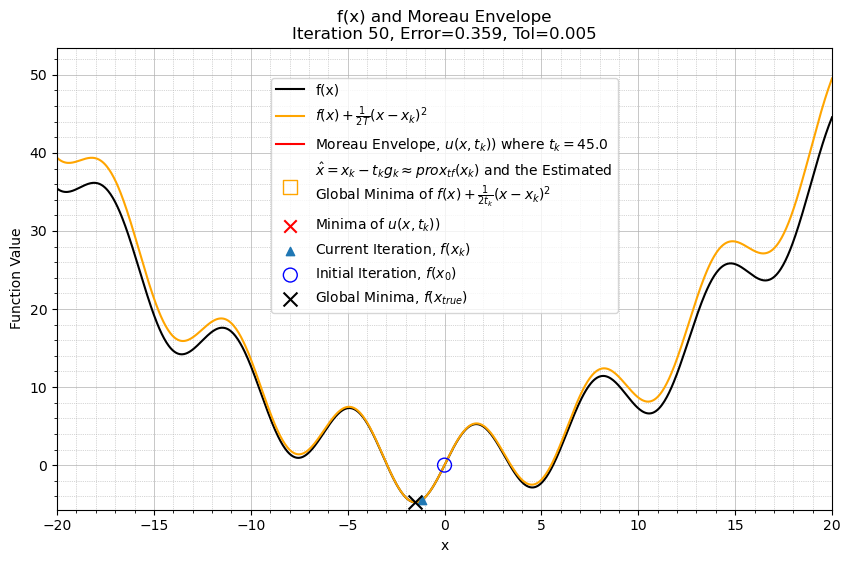

-------------------------- RUNNING HJ-MAD ---------------------------
dimension = 1, n_samples =  11
-------------------------- HJ-MAD RESULTS ---------------------------
HJ-MAD converged with rel grad norm 1.65e+00
iter =  26 , number of function evaluations =  297


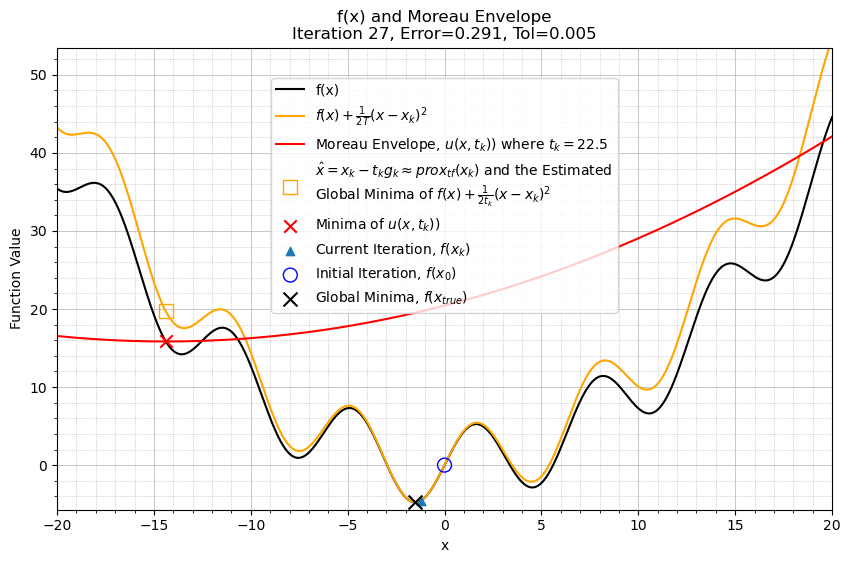

-------------------------- RUNNING HJ-MAD ---------------------------
dimension = 1, n_samples =  11


In [15]:
UI= HJ_MAD_UI()
